## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [88]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Data Load

In [89]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

In [90]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [91]:
IVF_categorical_columns = [
    "시술_시기_코드", 
    "시술_당시_나이", 
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "배아_생성_주요_이유",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]

In [92]:
DI_categorical_columns = [
    "시술_시기_코드", 
    "시술_당시_나이", 
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [93]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

In [94]:
# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

In [95]:
# import category_encoders as ce

# # 모든 범주형 변수를 문자열로 변환
# IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
# DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
# IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
# DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# # 타겟 인코더를 사용하여 범주형 변수 인코딩
# IVF_target_encoder = ce.TargetEncoder(cols=IVF_categorical_columns)
# DI_target_encoder = ce.TargetEncoder(cols=DI_categorical_columns)

# # 타겟 인코딩을 위해 타겟 변수가 필요합니다. 예시로 IVF_y와 DI_y를 사용합니다.
# IVF_X[IVF_categorical_columns] = IVF_target_encoder.fit_transform(IVF_X[IVF_categorical_columns], IVF_y)
# DI_X[DI_categorical_columns] = DI_target_encoder.fit_transform(DI_X[DI_categorical_columns], DI_y)
# IVF_test[IVF_categorical_columns] = IVF_target_encoder.transform(IVF_test[IVF_categorical_columns])
# DI_test[DI_categorical_columns] = DI_target_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [96]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)


--- Model Performance ---
Model Accuracy: 0.7444213388786691
Model F1 Score: 0.15328563857975624
Model AUC: 0.7406765225232976


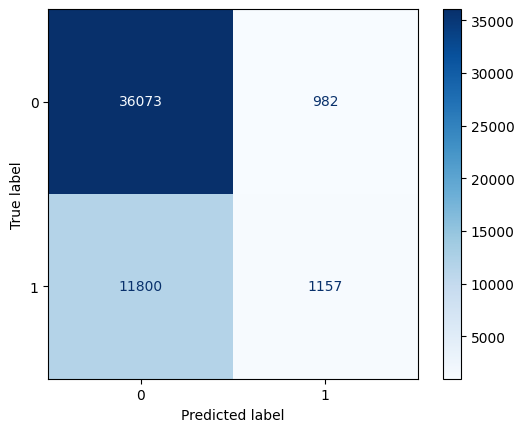

In [97]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 초기화
IVF_model = CatBoostClassifier(
    iterations=680,
    depth=10,
    learning_rate=0.01,
    random_seed=42,
    verbose=0
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8656597774244833
Model F1 Score: 0.0
Model AUC: 0.7073885976408912


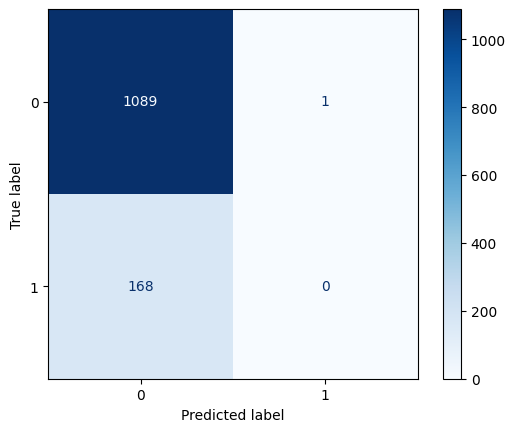

In [100]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 초기화
DI_model = CatBoostClassifier(
    iterations=500,
    depth=10,
    learning_rate=0.01,
    random_seed=42,
    verbose=0
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7473961380924518
Model F1 Score: 0.15158860137569602
Model AUC: 0.7422647346903108


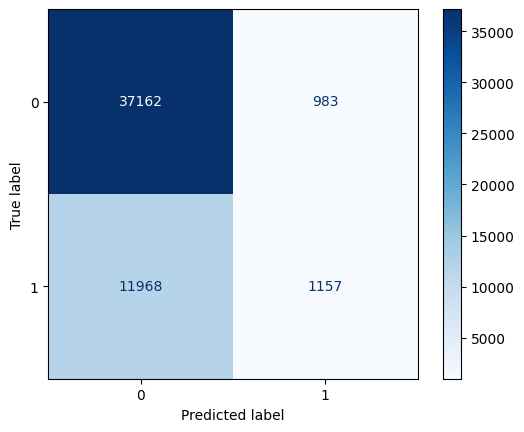

In [101]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [102]:
# 모델 구축
IVF_model = CatBoostClassifier(
    iterations=680,
    depth=10,
    learning_rate=0.01,
    random_seed=42,
    verbose=0
)

DI_model = CatBoostClassifier(
    iterations=500,
    depth=10,
    learning_rate=0.01,
    random_seed=42,
    verbose=0
)

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [61]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('./code14_submit.csv', index=False, encoding='utf-8')

.